In [1]:
import numpy as np
import pandas as pd


In [2]:
!wget -O leads.csv https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv


--2025-10-26 05:02:58--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘leads.csv’

leads.csv           100%[===================>]  78.98K  --.-KB/s    in 0.07s   

2025-10-26 05:02:59 (1.04 MB/s) - ‘leads.csv’ saved [80876/80876]



In [3]:
df=pd.read_csv("leads.csv")
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [4]:
categorical=['lead_source', 'industry','employment_status', 'location']
numerical=['number_of_courses_viewed', 'annual_income','interaction_count', 'lead_score']

In [5]:
df[categorical].isnull().sum()

lead_source          128
industry             134
employment_status    100
location              63
dtype: int64

In [6]:
df[categorical]=df[categorical].fillna("NA")

In [7]:
df[categorical].isnull().sum()

lead_source          0
industry             0
employment_status    0
location             0
dtype: int64

In [8]:
df[numerical].isnull().sum()

number_of_courses_viewed      0
annual_income               181
interaction_count             0
lead_score                    0
dtype: int64

In [9]:
df[numerical]=df[numerical].fillna(0)

In [10]:
df[numerical].isnull().sum()


number_of_courses_viewed    0
annual_income               0
interaction_count           0
lead_score                  0
dtype: int64

In [11]:
from sklearn.model_selection import train_test_split
df_full_train,df_test=train_test_split(df,test_size=0.2,random_state=1)
df_train,df_val=train_test_split(df_full_train,test_size=0.25,random_state=1)

In [ ]:
df_train=df_train.reset_index(drop=True)
df_val=df_val.reset_index(drop=True)
df_test=df_test.reset_index(drop=True)

y_train = df_train['converted'].values
y_val   = df_val['converted'].values
y_test  = df_test['converted'].values


In [17]:
from sklearn.metrics import roc_auc_score
m=0
column=""

for c in numerical:
    if (roc_auc_score(y_train,df_train[c])<0):
        score=roc_auc_score(y_train,-df_train[c])
    else:
        score=roc_auc_score(y_train,df_train[c])
    if(score>m):
        column=c
        m=score
    print(c,":",score)
print()
print(column,"has the highest aoc score")


number_of_courses_viewed : 0.7635680590007088
annual_income : 0.5519578313253012
interaction_count : 0.738270176293409
lead_score : 0.6144993577250176

number_of_courses_viewed has the highest aoc score


In [18]:
from sklearn.feature_extraction import DictVectorizer
dicts=df_train[categorical+numerical].to_dict(orient="records")
dv=DictVectorizer(sparse=False)
X_train=dv.fit_transform(dicts)
dicts1=df_val[categorical+numerical].to_dict(orient="records")

X_val=dv.transform(dicts1)


In [34]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train,y_train)

y_pred=model.predict(X_val)
roc_auc_score(y_val,y_pred)

0.647564950627936

0.64


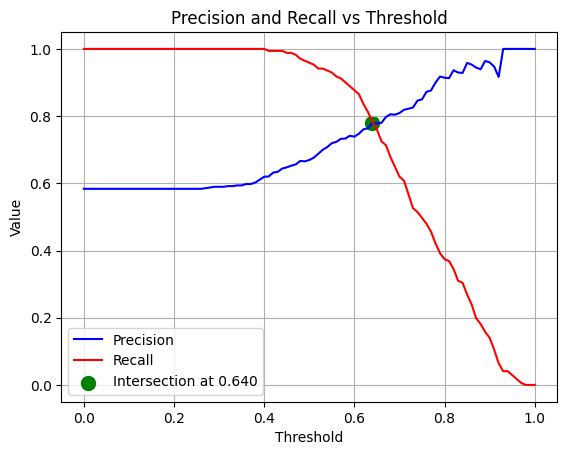

In [47]:
import numpy as np
import matplotlib.pyplot as plt
y_pred=model.predict_proba(X_val)[:,1]
thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []
f1=[]
for t in thresholds:
    actual_pos = (y_val == 1)
    actual_neg = (y_val == 0)
    predict_pos = (y_pred >= t)
    predict_neg = (y_pred < t)
    
    tp = (predict_pos & actual_pos).sum()
    tn = (predict_neg & actual_neg).sum()
    fp = (predict_pos & actual_neg).sum()
    fn = (predict_neg & actual_pos).sum()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 1.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    
    precisions.append(precision)
    recalls.append(recall)
    score=2*precision*recall/(precision+recall) 
    f1.append(score)

precisions = np.array(precisions)
recalls = np.array(recalls)

diff = np.abs(precisions - recalls)
idx = np.argmin(diff)
intersect = thresholds[idx]

print(intersect)


plt.plot(thresholds, precisions, color="blue", label="Precision")
plt.plot(thresholds, recalls, color="red", label="Recall")
plt.scatter(intersect, precisions[idx], color="green", s=100, label=f"Intersection at {intersect:.3f}")
plt.xlabel("Threshold")
plt.ylabel("Value")
plt.title("Precision and Recall vs Threshold")
plt.legend()
plt.grid(True)



0.5700000000000001


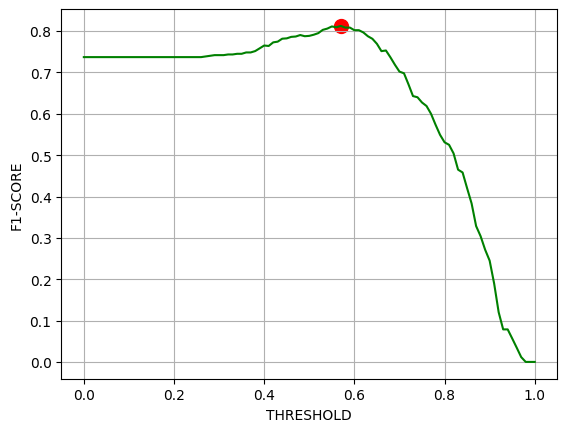

In [48]:
f1= np.array(f1)
inde=np.argmax(f1)
m=thresholds[inde]
print(m)
plt.plot(thresholds,f1,color="green")
plt.scatter(m,f1[inde], color="red",s=100,  label=f"MAX AT {m:.3f}")
plt.xlabel("THRESHOLD")
plt.ylabel("F1-SCORE")
plt.grid(True)


In [55]:
def train(df, y,C):
    dicts = df[categorical + numerical].to_dict(orient="records")
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y)
    return dv, model

def predict(df,dv,model):
    dicts=df[categorical+numerical].to_dict(orient='records')
    X=dv.transform(dicts)
    y_pred=model.predict_proba(X)[:,1]
    return y_pred

    
from sklearn.model_selection import KFold

kfold=KFold(n_splits=5, shuffle=True, random_state=1)
for c in [0.000001, 0.001, 1]:
    scores=[]
    for train_idx,val_idx in kfold.split(df_full_train):
        df_train=df_full_train.iloc[train_idx]
        df_val=df_full_train.iloc[val_idx]
        y_train=df_train.converted.values
        y_val=df_val.converted.values
        dv,model=train(df_train,y_train,c)
        y_pred=predict(df_val,dv,model)
        auc=roc_auc_score(y_val,y_pred)
        scores.append(auc)
    scores=np.array(scores)
    std=np.std(scores)
    mean=np.mean(scores)
    print(c,": MEAN:",mean,"STD: ",std)






1e-06 : MEAN: 0.560207852870275 STD:  0.023798316620649906
0.001 : MEAN: 0.8668780317675395 STD:  0.028746230508215103
1 : MEAN: 0.8221089148573075 STD:  0.03580711942905165
